In [5]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import Ian_functions as load
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'
old_path = '2012_data/'

In [55]:
reload(load);

In [56]:
#loads the data in, third argument is the file type u16 is uint16 u32 is uint32 and s32 is signed int32
ra = load.loadArbData(old_path, 'ra', 'u32')
dec = load.loadArbData(old_path, 'dec', 's32')
bolo = load.loadArbData(old_path, 'n29c05', 'u32')

In [57]:
max(ra), max (dec), max(bolo)

(4294964038, 221628191, 8597844)

In [58]:
len(ra), len(dec), len(bolo)/len(ra)

(5874590, 5874590, 20)

In [ ]:
# linear combination values to convert RA, DEC, and BOLO data to useful numbers from their dirfile values
# RA               LINCOM 1 ra               5.587935447693e-09 0.000000000000e+00
# DEC              LINCOM 1 dec              8.381903171539e-08 0.000000000000e+00
# N29C05           LINCOM 1 n29c05           6.903363270000e-07 -5.787153550000e+00

In [59]:
ra_a =  5.587935447693e-09
ra_b = 0
dec_a = 8.381903171539e-08
dec_b = 0
bolo_a = 6.903363270000e-07
bolo_b = -5.787153550000e+00

In [60]:
# conversion from dirfiles to useful data
bolo = bolo_a*bolo + bolo_b
ra = ra*ra_a
dec = dec*dec_a

In [61]:
# sanity check
max(bolo), max(ra), max(dec)

(0.14825049707898774, 23.999981794506866, 18.57666037045351)

In [78]:
# start of setting plotting ranges, probably should interpolate the data to bring ra dec to 100hz from 5hz
bolo_start = 0
bolo_range = 1
slow_range = bolo_range/20
slow_start = bolo_start/20

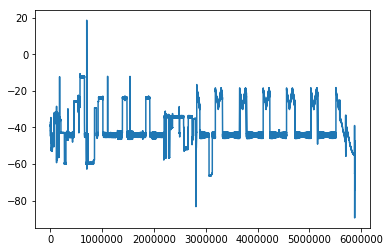

In [62]:
# more sanity check plots, make sure values are reasonable
plt.plot(dec)

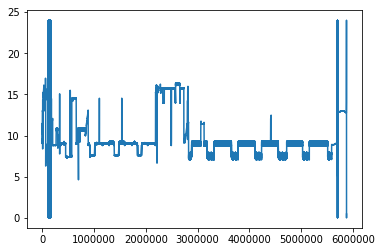

In [64]:
plt.plot(ra)

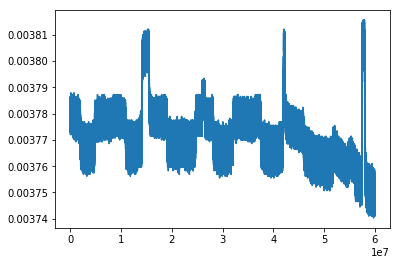

In [74]:
plt.plot(bolo[30000000:90000000])